In [1]:
import numpy as np
import scipy as sp
from scipy import optimize
from scipy import stats
import matplotlib.pyplot as plt
import sys, copy, emcee, corner
%matplotlib inline

In [2]:
sys.path.append('./ligbind/')
import ligbind as lb

In [3]:
def wym_obj(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)

def fit_wym(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)
    
def wym_obj_wt(guess,model,data,ligs,rtot):
    datac = np.concatenate(data)
    return (model(guess,ligs,rtot)-datac)/datac

def fit_wym_wt(guess,model,data,ligs,rtot,bnds):
        return sp.optimize.least_squares(wym_obj_wt,guess,args=(model,data,ligs,rtot),bounds=bnds,method='trf',ftol=1e-14,gtol=1e-14,xtol=1e-14)

In [4]:
def wymfunc_fix(parm,lig,rtot):
    '''
    Model function for dimerizing, single-site receptors as derived in
    (Wyman and Gill, Binding and Linkage, 1990) and used by
    (Macdonald and Pike, ...EGF-binding...negative cooperativity...aggregating system, 2008).
    Takes numpy array of parameters [k11,k21,k22,l20], numpy array of free ligand concentrations,
    and total receptor concentration. Returns the fraction of receptor bound to ligand.

    To generate a data set, iterate over an array of desired receptor concentrations, e.g.:
    [wymfunc(parm,lig,i) for i in array_of_rtots]

    For use in curve fitting an objective function for use with scipy.optimize.least_squares
    is readily constructed as: (wymfun(parm_guess,lig,rtot) - actual_data)
    '''

    #ensure dimension/broadcasting compatibility of inputs
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        rtot = rtot[:,None] #adds dimension so that it can be broadcast
    else:
        rtot = rtot

    #unpack parameters
    k11 = parm[0]
    k21 = parm[1]
    k22 = k21/4.
    l20 = parm[2]

    ### START MODEL FUNCTION ###

    #calculate concentration of free (unoccupied) receptor
    rfree = (((-1 - k11*lig)) + \
    ((np.square((1 + k11*lig)) + \
    8.*l20*rtot*(1 + k21*lig + k21*k22*(np.square(lig)))))**0.5) \
    / (4*l20*(1 + k21*lig + k21*k22*(np.square(lig))))

    #calculate bound fraction
    bfrac = (k11*lig + l20*k21*rfree*lig + \
    2*l20*k21*k22*rfree*(np.square(lig))) \
    / (1 + 2*l20*rfree + k11*lig + \
    2*l20*k21*rfree*lig + 2*l20*k21*k22*rfree*(np.square(lig)))

    ### END MODEL FUNCTION ###

    #flatten output
    if ((rtot.ndim > 0) and (rtot.ndim != lig.ndim)):
        return bfrac.flatten()
    elif (rtot.ndim == 0):
        return bfrac.flatten()
    else:
        return np.concatenate(bfrac)

In [5]:
from itertools import product

def parmsetter(k1):
    base = np.array([k1,])
    k2s = np.array([0.1,1.,10.])*base
    k21s = np.array([1000.,100.,10.,0.1,0.01,0.001])*base
    ls = np.array([10.,100.,1000.])*base
    
    things = [base,k2s,k21s,ls]
    
    b = list(product(*things))
    
    c = np.array(b)
    
    c[:,2]=c[:,1]/4.
    
    neuts = np.array(list(set([tuple(i.tolist()) for i in c])))
    
    all_sets = np.concatenate([b,neuts])
    
    return all_sets

In [6]:
parmsets = parmsetter(5)

In [7]:
sim_n05_pre = [lb.WymSimSubset(sets=1000,reps=1,parms=i,noise=0.05) for i in parmsets]

In [8]:
low = copy.deepcopy(sim_n05_pre)
mid = copy.deepcopy(sim_n05_pre)
hi = copy.deepcopy(sim_n05_pre)

[i.subset(0,9) for i in low];
[i.subset(4,14) for i in mid];
[i.subset(9,18) for i in hi];

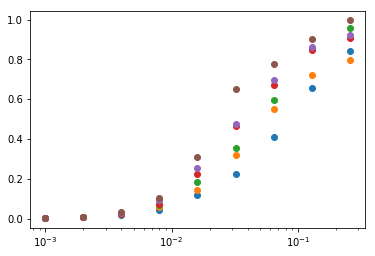

In [9]:
for i in range(6):
    plt.semilogx(low[0].ligs[i],low[0].meanset[0][i],'o')

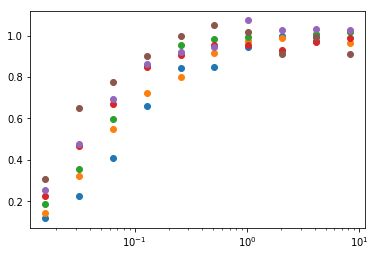

In [10]:
for i in range(6):
    plt.semilogx(mid[0].ligs[i],mid[0].meanset[0][i],'o')

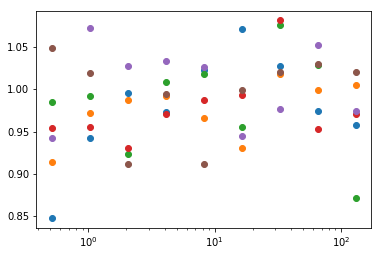

In [11]:
for i in range(6):
    plt.semilogx(hi[0].ligs[i],hi[0].meanset[0][i],'o')

In [12]:
parmsets_fix = np.array([np.append(i[0:2],i[-1]) for i in parmsets])

In [13]:
type(parmsets_fix)

numpy.ndarray

In [14]:
lsbnds = (tuple(1e-5 for i in range(4)),tuple(1e4 for i in range(4)))
lsbnds_fix = (tuple(1e-5 for i in range(3)),tuple(1e4 for i in range(3)))

In [15]:
#%time midtrunc_full_wt_REAL = [np.array([fit_wym_wt(parmsets[j],lb.models.wymfunc,mid[j].meanset[i],mid[j].ligs,mid[j].rtot,lsbnds) for i in range(1000)]) for j in range(len(mid))]

In [16]:
#%time midtrunc_fix_wt_REAL = [np.array([fit_wym_wt(parmsets_fix[j],wymfunc_fix,mid[j].meanset[i],mid[j].ligs,mid[j].rtot,lsbnds_fix) for i in range(1000)]) for j in range(len(mid))]

In [17]:
#mids_fix = np.array(midtrunc_fix_wt_REAL)

In [18]:
#mids_full = np.array(midtrunc_full_wt_REAL)

In [19]:
#%store mids_fix

In [20]:
#%store mids_full

In [21]:
%store -r

In [41]:
mids_fix[0][0].x

array([  8.20679471e+00,   1.00000000e+04,   1.32494909e-03])

In [42]:
def ftest(fit1,fit2):
    '''
    fit1 is fit from simpler model
    '''

    SS1 = np.sum(np.square(fit1.fun))
    SS2 = np.sum(np.square(fit2.fun))

    DF1 = fit1.fun.shape[0] - fit1.x.shape[0]
    DF2 = fit2.fun.shape[0] - fit2.x.shape[0]

    F = ((SS1-SS2)/(DF1-DF2))/(SS2/DF2)

    p = sp.stats.f.sf(F,(DF1-DF2),DF2)

    return (SS1,SS2,DF1,DF2,F,p)

In [43]:
ps = np.array([np.array([ftest(mids_fix[j][i],mids_full[j][i])[-1] for i in range(1000)]) for j in range(63)])

In [44]:
parmsets

array([[  5.00000000e+00,   5.00000000e-01,   5.00000000e+03,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+03,
          5.00000000e+02],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+03,
          5.00000000e+03],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+02,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+02,
          5.00000000e+02],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+02,
          5.00000000e+03],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+01,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+01,
          5.00000000e+02],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e+01,
          5.00000000e+03],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e-01,
          5.00000000e+01],
       [  5.00000000e+00,   5.00000000e-01,   5.00000000e-01,
          5.00000000e+02],
       [  5.00000000e

In [45]:
sigs = np.array([np.sum(ps[i] < 0.05) for i in range(63)])

In [46]:
sigs

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,   36,  532,
       1000,   21,   48,  862,   15,  107, 1000,  405,  399,  387, 1000,
       1000, 1000, 1000, 1000, 1000,  836, 1000, 1000,  998, 1000, 1000,
       1000, 1000, 1000,    2,    1,    1,  334,  330,  294,  996, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,   57,
         78,   22,   59,   62,   64,   61,   26,   60])

In [47]:
np.std(sigs)

425.64031529512698

In [48]:
labled_sigs = np.array([i for i in enumerate(sigs)])

In [49]:
labled_sigs[labled_sigs[:,1].argsort()]

array([[  38,    1],
       [  37,    1],
       [  36,    2],
       [  15,   15],
       [  12,   21],
       [  56,   22],
       [  61,   26],
       [   9,   36],
       [  13,   48],
       [  54,   57],
       [  57,   59],
       [  62,   60],
       [  60,   61],
       [  58,   62],
       [  59,   64],
       [  55,   78],
       [  16,  107],
       [  41,  294],
       [  40,  330],
       [  39,  334],
       [  20,  387],
       [  19,  399],
       [  18,  405],
       [  10,  532],
       [  27,  836],
       [  14,  862],
       [  42,  996],
       [  30,  998],
       [  47, 1000],
       [  52, 1000],
       [  45, 1000],
       [  44, 1000],
       [  43, 1000],
       [  49, 1000],
       [  50, 1000],
       [  51, 1000],
       [  53, 1000],
       [  48, 1000],
       [  46, 1000],
       [   0, 1000],
       [  34, 1000],
       [   1, 1000],
       [   2, 1000],
       [   3, 1000],
       [   4, 1000],
       [   5, 1000],
       [   6, 1000],
       [   7,

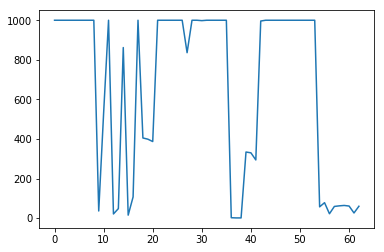

In [50]:
plt.plot(labled_sigs[:,0],labled_sigs[:,1])

In [51]:
full_from_other_sheet = np.array([19, 35, 63, 15, 41, 52, 21, 32, 54, 16, 37, 71, 15, 25, 63,  6, 33,
       73, 69, 74, 71, 74, 54, 61, 68, 64, 66, 62, 70, 73, 60, 69, 70, 91,
       70, 74, 64, 61, 60, 60, 60, 75, 68, 66, 75, 62, 78, 70, 57, 75, 65,
       53, 66, 61, 69, 80, 13, 57, 60, 74, 76, 33, 59])

In [52]:
ffo = np.array([i for i in enumerate(full_from_other_sheet)])

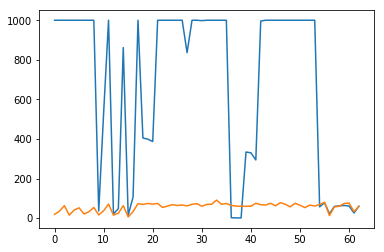

In [53]:
plt.plot(labled_sigs[:,0],labled_sigs[:,1])
plt.plot(ffo[:,0],ffo[:,1])

In [56]:
parmsets.tolist()

[[5.0, 0.5, 5000.0, 50.0],
 [5.0, 0.5, 5000.0, 500.0],
 [5.0, 0.5, 5000.0, 5000.0],
 [5.0, 0.5, 500.0, 50.0],
 [5.0, 0.5, 500.0, 500.0],
 [5.0, 0.5, 500.0, 5000.0],
 [5.0, 0.5, 50.0, 50.0],
 [5.0, 0.5, 50.0, 500.0],
 [5.0, 0.5, 50.0, 5000.0],
 [5.0, 0.5, 0.5, 50.0],
 [5.0, 0.5, 0.5, 500.0],
 [5.0, 0.5, 0.5, 5000.0],
 [5.0, 0.5, 0.05, 50.0],
 [5.0, 0.5, 0.05, 500.0],
 [5.0, 0.5, 0.05, 5000.0],
 [5.0, 0.5, 0.005, 50.0],
 [5.0, 0.5, 0.005, 500.0],
 [5.0, 0.5, 0.005, 5000.0],
 [5.0, 5.0, 5000.0, 50.0],
 [5.0, 5.0, 5000.0, 500.0],
 [5.0, 5.0, 5000.0, 5000.0],
 [5.0, 5.0, 500.0, 50.0],
 [5.0, 5.0, 500.0, 500.0],
 [5.0, 5.0, 500.0, 5000.0],
 [5.0, 5.0, 50.0, 50.0],
 [5.0, 5.0, 50.0, 500.0],
 [5.0, 5.0, 50.0, 5000.0],
 [5.0, 5.0, 0.5, 50.0],
 [5.0, 5.0, 0.5, 500.0],
 [5.0, 5.0, 0.5, 5000.0],
 [5.0, 5.0, 0.05, 50.0],
 [5.0, 5.0, 0.05, 500.0],
 [5.0, 5.0, 0.05, 5000.0],
 [5.0, 5.0, 0.005, 50.0],
 [5.0, 5.0, 0.005, 500.0],
 [5.0, 5.0, 0.005, 5000.0],
 [5.0, 50.0, 5000.0, 50.0],
 [5.0, 50.0, 5000.

In [57]:
parmsets[:,0] + parmsets[:,1] + parmsets[:,2] + parmsets[:,3]

array([  5055.5  ,   5505.5  ,  10005.5  ,    555.5  ,   1005.5  ,
         5505.5  ,    105.5  ,    555.5  ,   5055.5  ,     56.   ,
          506.   ,   5006.   ,     55.55 ,    505.55 ,   5005.55 ,
           55.505,    505.505,   5005.505,   5060.   ,   5510.   ,
        10010.   ,    560.   ,   1010.   ,   5510.   ,    110.   ,
          560.   ,   5060.   ,     60.5  ,    510.5  ,   5010.5  ,
           60.05 ,    510.05 ,   5010.05 ,     60.005,    510.005,
         5010.005,   5105.   ,   5555.   ,  10055.   ,    605.   ,
         1055.   ,   5555.   ,    155.   ,    605.   ,   5105.   ,
          105.5  ,    555.5  ,   5055.5  ,    105.05 ,    555.05 ,
         5055.05 ,    105.005,    555.005,   5055.005,    567.5  ,
         5067.5  ,     55.625,    117.5  ,   5005.625,    511.25 ,
         5011.25 ,    505.625,     61.25 ])

In [58]:
parmsets[0]

array([  5.00000000e+00,   5.00000000e-01,   5.00000000e+03,
         5.00000000e+01])

In [59]:
parmsets[3]

array([   5. ,    0.5,  500. ,   50. ])

In [39]:
#%time lowtrunc_full_wt_REAL = [np.array([fit_wym_wt(parmsets[j],lb.models.wymfunc,low[j].meanset[i],low[j].ligs,low[j].rtot,lsbnds) for i in range(1000)]) for j in range(len(low))]

CPU times: user 21min 42s, sys: 4.73 s, total: 21min 46s
Wall time: 21min 50s


In [40]:
#%time lowtrunc_fix_wt_REAL = [np.array([fit_wym_wt(parmsets_fix[j],wymfunc_fix,low[j].meanset[i],low[j].ligs,low[j].rtot,lsbnds_fix) for i in range(1000)]) for j in range(len(low))]

CPU times: user 29min 52s, sys: 5.6 s, total: 29min 58s
Wall time: 30min


In [60]:
#low_full = np.array(lowtrunc_full_wt_REAL)

In [61]:
#low_fix = np.array(lowtrunc_fix_wt_REAL)

In [62]:
#%store low_full

Stored 'low_full' (ndarray)


In [63]:
#%store low_fix

Stored 'low_fix' (ndarray)


In [64]:
ps_low = np.array([np.array([ftest(low_fix[j][i],low_full[j][i])[-1] for i in range(1000)]) for j in range(63)])

In [66]:
sigs_low = np.array([np.sum(ps_low[i] < 0.05) for i in range(63)])

In [67]:
sigs_low

array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,   40,  128,
        643,   15,   15,   32,   19,    9,   37, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000,  573,  997, 1000,  936, 1000, 1000,
        959, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,
       1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000,   57,
         66,   19,   49,   30,   51,   59,   19,   42])

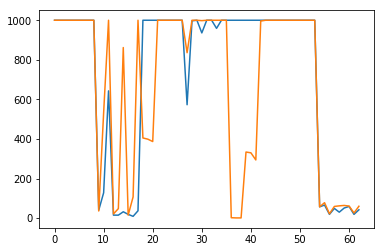

In [69]:
plt.plot(sigs_low)
plt.plot(sigs)